In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd '/content/drive/MyDrive/codigos_de_clase'

/content/drive/Othercomputers/My Laptop/codigos_de_clase


### Cargamos el dataset usando Keras

Este conjunto de datos Fashion MNIST contiene 70000 imágenes de ropa y accesorios. Cada imagen está en escala de grises y tiene una resolución de 28x28 píxeles. El conjunto de datos se compone de 10 clases diferentes de prendas y accesorios, incluyendo camisetas, pantalones, vestidos, zapatillas, bolsos, entre otros.

El conjunto de datos ya está dividido en un conjunto de entrenamiento (60,000 imágenes) y un conjunto de prueba (10,000 imágenes), pero puede ser útil dividir aún más el conjunto de entrenamiento para obtener un conjunto de validación. Utilizaremos 55,000 imágenes para el entrenamiento y 5,000 para la validación.

In [2]:
fashion_mnist =tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print("Dimensión de los datos de entrenamiento: ", X_train.shape)
print("Dimensión de los datos de validación: ", X_valid.shape)
print("Dimensión de los datos de prueba: ", X_test.shape)

Dimensión de los datos de entrenamiento:  (55000, 28, 28)
Dimensión de los datos de validación:  (5000, 28, 28)
Dimensión de los datos de prueba:  (10000, 28, 28)



Como vamos a utilizar el algoritmo del descenso del gradiente, vamos a escalar las intensidades de los píxeles al rango de 0 a 1 y convertirlas en números decimales, dividiendo por 255:

In [3]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Si observamos las etiquetas:

In [4]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Veremos sólo números, estos números corresponden a las siguientes etiquetas, estas se encuentran en la documentación oficial del [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist)

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Entonces la primera imagen en el conjunto de entrenamiento sería:

In [6]:
class_names[y_train[0]]

'Ankle boot'

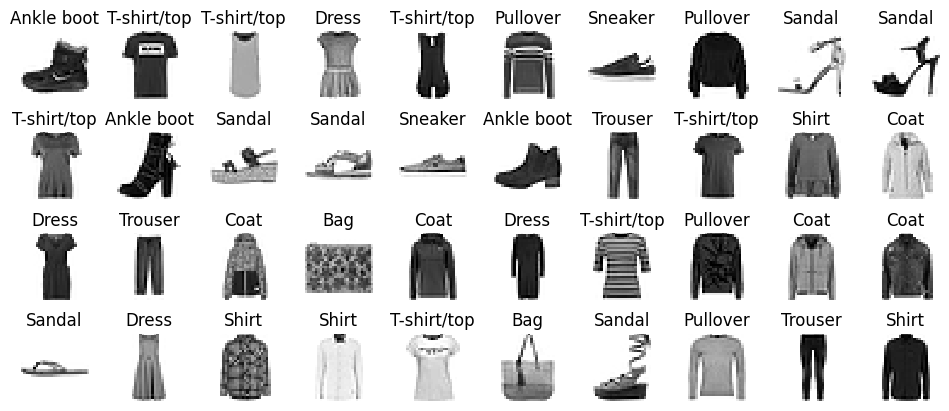

In [7]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Creamos el PMC

Vamos a crear un modelo con 2 capas ocultas usando una API secuencial, es decir la red neuronal está compuesta de capas apiladas conectadas secuencialmente.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42) # semilla aleatoria para tensorflow, python y numpy

model = tf.keras.models.Sequential() # crea el modelo secuencial
model.add(tf.keras.layers.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten()) # capa Flatten, su función es convertir cada imagen en un arreglo 1D (X.reshape(-1,1))
model.add(tf.keras.layers.Dense(300, activation="relu")) # capa Dense oculta con 300 nodos, usa la función de activación ReLU
model.add(tf.keras.layers.Dense(100, activation="relu")) # capa Dense oculta con 100 nodos, usa la función de activación ReLU
model.add(tf.keras.layers.Dense(10, activation="softmax")) # capa Dense de salida con 10 nodos, usa la función de activación softmax

De forma opcional se puede definir la función de activación de esta forma `activation = tf.keras.activations.relu()`
En la capa de salida usamos la función de activación _softmax_, se utiliza comúnmente en problemas de clasificación multiclase excluyentes entre clases, donde deseas asignar una instancia de entrada a una de varias clases posibles. Transforma las salidas lineales en probabilidades que representan la probabilidad de que la entrada pertenezca a cada clase. La suma de todas las probabilidades calculadas por la función Softmax será igual a 1.

[funciones de activación](https://keras.io/api/layers/activations/)

In [ ]:
# Otra opción usando una lista de capas
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[28, 28]),
#     tf.keras.layers.Dense(300, activation="relu"),
#     tf.keras.layers.Dense(100, activation="relu"),
#     tf.keras.layers.Dense(10, activation="softmax")
# ])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notar que el número de parámetros después de la primera capa oculta $235500 = (784 \cdot 300) + 300$

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model.layers[1].name

'dense'

In [12]:
hidden1 = model.layers[1]

In [13]:
model.get_layer('dense') is hidden1

True

Se pueden acceder a los pesos de una capa (incluyendo términos de bias) usando el método `get_weights()`. También se podrían modificar usando `set_weights()`

In [14]:
weights, biases = hidden1.get_weights()
print("Dimensión de la matriz de pesos de hidden1: ", weights.shape)
print("Dimensión de la matriz de biases de hidden1: ", biases.shape)

Dimensión de la matriz de pesos de hidden1:  (784, 300)
Dimensión de la matriz de biases de hidden1:  (300,)


Los pesos se inicializan aleatoriamente y los biases en cero, se pueden inicializar usando otros métodos usando los parámetros `kernel_initializer` y `bias_initializer` al crear la capa.

[métodos de inicialización](https://keras.io/api/layers/initializers/)

In [15]:
weights

array([[ 0.04183312, -0.06284215,  0.00168013, ...,  0.03517966,
        -0.01337954,  0.03826314],
       [ 0.03529113,  0.0396752 , -0.03642321, ..., -0.01632214,
         0.00443822, -0.0500754 ],
       [ 0.05088116,  0.06589586,  0.00984646, ...,  0.01576727,
        -0.01362462, -0.00950089],
       ...,
       [ 0.04085102,  0.04354531, -0.0143766 , ..., -0.06919684,
        -0.06834038,  0.06302635],
       [ 0.0567193 , -0.06635454, -0.05460579, ...,  0.02680069,
         0.06835197, -0.04108901],
       [-0.01292419, -0.00517839, -0.00011779, ...,  0.02407609,
        -0.06473063, -0.02398074]], dtype=float32)

In [16]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Compilar el modelo

Después de crear el modelo, se debe llamar a su método `compile()` para especificar la función de pérdida y el algoritmo de optimización a utilizar durante el entrenamiento. De manera opcional, se pueden especificar métricas adicionales a calcular durante el entrenamiento y validación.

- [Funciones de pérdida](https://keras.io/api/losses)
- [Métricas](https://keras.io/api/metrics)
- [Funciones de optimización](https://keras.io/api/optimizers)

In [17]:
# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer="sgd",
#               metrics=["accuracy"])

#Código equivalente
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

la función de pérdida `sparse_categorical_crossentropy` espera que los targets estén dados como enteros, en este caso se usa porque tenemos 10 clases, representadas con enteros y las clases son excluyentes.

### Entrenamiento y evaluación del modelo

Además del conjunto de entrenamiento, también pasamos un conjunto de validación (opcional). Se mide el error y las métricas adicionales en este conjunto al final de cada época. Si el desempeño en el conjunto de entrenamiento es mucho mejor que en el conjunto de validación, es probable que el modelo esté sobreajustando el conjunto de entrenamiento o que haya un error, como una discrepancia de datos entre el conjunto de entrenamiento y el conjunto de validación.

In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7084 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.5000 - val_sparse_categorical_accuracy: 0.8284
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4852 - sparse_categorical_accuracy: 0.8315 - val_loss: 0.4579 - val_sparse_categorical_accuracy: 0.8364
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4392 - sparse_categorical_accuracy: 0.8464 - val_loss: 0.4213 - val_sparse_categorical_accuracy: 0.8492
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4150 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8610
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.3889 - val_sparse_categorical_accuracy: 0.8582
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3773 - spa

Como no se define un tamaño de lote de datos (batch size) este es por defecto 32. Como el conjunto de entrenamiento tiene 55000 imágenes, el modelo usa 1719 lotes por época (1718 lotes de 32 datos y uno de 24)

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
import pandas as pd

epochs_info_1 = pd.DataFrame(history.history)
epochs_info_1

In [ ]:
epochs_info_1.plot(
    figsize=(12, 7), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"]
)
plt.legend(loc='lower left')
plt.show()

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
epochs_info_2 = pd.concat((epochs_info_1, pd.DataFrame(history.history)), axis=0, ignore_index=True)
epochs_info_2.plot(
    figsize=(12, 7), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"]
)
plt.legend(loc='lower left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

### Realizar predicciones usando el modelo.

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(3)

In [ ]:
y_pred = y_proba.argmax(axis=-1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3]
y_new

### TensorBoard

TensorBoard es una herramienta de visualización interactiva para ver las curvas de entrenamiento, comparar curvas y métricas entre múltiples ejecuciones, visualizar el gráfico de computación, analizar estadísticas de entrenamiento, ver imágenes generadas por tu modelo, visualizar datos multidimensionales complejos proyectados en 3D y agrupados automáticamente ,TensorBoard se instala automáticamente cuando instalas TensorFlow.

En Colab `%pip install -q -U tensorboard-plugin-profile`

Vamos a nombrar el directorio raíz de registro como "logs", y vamos a definir una función que genere la ruta del subdirectorio de registro basándose en la fecha y la hora actual, de modo que sea diferente en cada ejecución.

In [ ]:
#%pip install -q -U tensorboard-plugin-profile

In [ ]:
#%load_ext tensorboard

In [ ]:
from pathlib import Path
import os
import datetime

run_logdir= os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%H%M%S") )
run_logdir

'logs\\20230903093101'

In [ ]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                histogram_freq = 1,
                                                profile_batch=(500, 520))


In [ ]:
tf.keras.backend.clear_session()

tf.random.set_seed(42) # semilla aleatoria para tensorflow, python y numpy
model = tf.keras.models.Sequential() # crea el modelo secuencial
model.add(tf.keras.layers.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten()) # capa Flatten, su función es convertir cada imagen en un arreglo 1D (X.reshape(-1,1))
model.add(tf.keras.layers.Dense(300, activation="relu")) # capa Dense oculta con 300 nodos, usa la función de activación ReLU
model.add(tf.keras.layers.Dense(100, activation="relu")) # capa Dense oculta con 100 nodos, usa la función de activación ReLU
model.add(tf.keras.layers.Dense(10, activation="softmax")) # capa Dense de salida con 10 nodos, usa la función de activación softmax


model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb])

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7158 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.5025 - val_sparse_categorical_accuracy: 0.8278
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4853 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.4608 - val_sparse_categorical_accuracy: 0.8318
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4387 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.4216 - val_sparse_categorical_accuracy: 0.8502
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.3975 - val_sparse_categorical_accuracy: 0.8588
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3944 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.3944 - val_sparse_categorical_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3780 - spars

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.8852


[0.32491257786750793, 0.885200023651123]

In [ ]:
print("logs")
for path in sorted(Path("logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

logs
  20230903093101
    plugins
      profile
        2023_09_03_12_33_56
          DESKTOP-T6C1FHS.xplane.pb
    train
      events.out.tfevents.1693744434.DESKTOP-T6C1FHS.38424.0.v2
      events.out.tfevents.1693744594.DESKTOP-T6C1FHS.38424.2.v2
    validation
      events.out.tfevents.1693744440.DESKTOP-T6C1FHS.38424.1.v2
      events.out.tfevents.1693744594.DESKTOP-T6C1FHS.38424.3.v2


In [ ]:
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

### Ajuste fino del modelo (Fine-Tuning)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [ ]:
import sys
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

La función debe tomar como argumento un objeto `kt.HyperParameters`, que se utiliza para definir hiperparámetros (enteros, flotantes, cadenas, etc.) junto con su rango de valores posibles, y estos hiperparámetros se utilizan para construir y compilar el modelo.

In [ ]:
#pip install keras-tuner --upgrade

def build_model(hp): # hp es un objeto de tipo kt.HyperParameters
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

La primera parte de la función define los hiperparámetros.
`hp.Int("n_hidden", min_value=0, max_value=8, default=2)` verifica si ya existe un hiperparámetro llamado `n_hidden` en el objeto HyperParameters `hp`, si es así, devuelve su valor. Si no existe, registra un nuevo hiperparámetro entero llamado "n_hidden", cuyos posibles valores van desde 0 hasta 8 (inclusive), y devuelve el valor predeterminado, que en este caso es 2 (cuando no se establece un valor predeterminado, se devuelve el valor mínimo, que es 2 en este caso).

El hiperparámetro `n_neurons` se registra de manera similar. El hiperparámetro `learning_rate` se registra como un número flotante (float) que varía en el rango de $10^{-4}$ a $10^{-2}$, y dado que `sampling="log"`, las tasas de aprendizaje de todas las escalas se muestrean por igual.

Por último, el hiperparámetro `optimizer` se registra con dos posibles valores: "sgd" o "adam" (el valor predeterminado es el primero, que en este caso es "sgd"). Dependiendo del valor de `optimizer`, se crea un optimizador SGD o un optimizador Adam con la tasa de aprendizaje proporcionada.

In [ ]:
import keras_tuner as kt

random_search_tuner = kt.RandomSearch(build_model,
                                      objective="val_accuracy",
                                      max_trials=5,
                                      overwrite=True,
                                      directory="fashion_mnist",
                                      project_name="my_rnd_search",
                                      seed=42)

In [ ]:
root_logdir = Path(random_search_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

In [ ]:
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb])

Trial 5 Complete [00h 00m 48s]
val_accuracy: 0.7735999822616577

Best val_accuracy So Far: 0.8605999946594238
Total elapsed time: 00h 04m 11s
INFO:tensorflow:Oracle triggered exit


Se pueden acceder a los mejores modelos así

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

También se puede llamar a `get_best_hyperparameters()` para obtener los hiperparámetros de los mejores modelos:

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 8,
 'n_neurons': 37,
 'learning_rate': 0.008547485565344062,
 'optimizer': 'sgd'}

Un "tuner" es una herramienta que ayuda a buscar la mejor combinación de hiperparámetros para un modelo de manera eficiente. Cada tuner está guiado por lo que se llama un "oracle". El oracle es una entidad que tiene conocimiento de todas las pruebas (combinaciones de hiperparámetros y sus resultados) realizadas durante el proceso de ajuste de hiperparámetros y ofrece recomendaciones sobre cuál debería ser la próxima prueba a realizar.

En este caso, el tuner utiliza un "RandomSearch Oracle" (Oracle de Búsqueda Aleatoria). Este tipo de oracle es bastante simple en su funcionamiento. En lugar de tomar decisiones basadas en la optimización inteligente, como algunos otros oráculos más avanzados, el RandomSearch Oracle selecciona la próxima prueba de manera completamente aleatoria. Esto significa que el tuner elige combinaciones de hiperparámetros al azar en cada intento sin una estrategia específica para buscar la mejor combinación.

El oracle realiza un seguimiento de todas las pruebas realizadas hasta el momento. Esto es importante porque, dado que el proceso es aleatorio, es posible que el tuner no siempre seleccione la mejor combinación de hiperparámetros en cada intento. Por lo tanto, el oracle puede mantener un registro de todas las pruebas y sus resultados para consultarle cuál fue la mejor prueba y un resumen de esa prueba.

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
n_hidden: 8
n_neurons: 37
learning_rate: 0.008547485565344062
optimizer: sgd
Score: 0.8605999946594238


In [ ]:
best_model.fit(X_train, y_train, epochs=20)

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3712 - accuracy: 0.8656
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3611 - accuracy: 0.8683
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3494 - accuracy: 0.8727
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3437 - accuracy: 0.8750
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3364 - accuracy: 0.8777
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3283 - accuracy: 0.8799
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3232 - accuracy: 0.8827
Epoch 8/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3180 - accuracy: 0.8845
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3121 - accuracy: 0.8862
Epoch 10/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.307

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3779 - accuracy: 0.8670
